In [ ]:
# git clone transformer_rankers to google drive
!git clone https://github.com/Guzpenha/transformer_rankers.git
%cd /content/transformer_rankers 
!apt-get install python3-venv
!python3 -m venv env
!source env/bin/activate

# set up the environment for transformer_rankers
!pip install -e .
!sed -i '/pandas/d' ./requirements.txt 
!sed -i '/numpy/d' ./requirements.txt 
!pip install -r requirements.txt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
cd 'content/drive/My Drive/transformer_rankers'

/content/drive/My Drive/transformer_rankers


# Negative sampling and preprocessing MANtIS

In [ ]:
# negative sampling to get negative samples (run twice for sbert)
!python examples/negative_sampling_bm25.py\
  --task mantis \
  --data_folder data\
  --output_dir examples\
  --anserini_folder anserini/\

2021-07-31 20:56:45.229739: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
2021-07-31 20:57:04,122 [INFO] Lock 140168799417616 acquired on /root/.cache/torch/transformers/5e8a2b4893d13790ed4150ca1906be5f7a03d6c4ddf62296c383f6db42814db2.e13dbb970cb325137104fb2e5f36fe865f27746c6b526f6352861b1980eb80b1.lock
2021-07-31 20:57:04,122 [INFO] https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-vocab.txt not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmpi8ctt4ec
Downloading: 100% 213k/213k [00:00<00:00, 286kB/s] 
2021-07-31 20:57:05,703 [INFO] storing https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-vocab.txt in cache at /root/.cache/torch/transformers/5e8a2b4893d13790ed4150ca1906be5f7a03d6c4ddf62296c383f6db42814db2.e13dbb970cb325137104f

In [ ]:
# re-generate valid with 9 negative samples 3h25m
!python examples/negative_sampling_bm25.py\
  --task mantis \
  --data_folder data\
  --output_dir examples\
  --anserini_folder anserini/\
  --num_ns_train 9\

2021-08-02 13:55:54.663765: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
2021-08-02 13:56:01,633 [INFO] loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-vocab.txt from cache at /root/.cache/torch/transformers/5e8a2b4893d13790ed4150ca1906be5f7a03d6c4ddf62296c383f6db42814db2.e13dbb970cb325137104fb2e5f36fe865f27746c6b526f6352861b1980eb80b1
QC: anserini/
QC: anserini/
2021-08-02 13:56:02,406 [INFO] Retrieving candidates using bm25 for test dataset
100% 17983/17983 [19:22<00:00, 15.46it/s]
2021-08-02 14:15:30,437 [INFO] Retrieving candidates using bm25 for valid dataset
100% 18096/18096 [18:58<00:00, 15.89it/s]


In [ ]:
import pandas as pd
import codecs

#Load the dataset
data_folder = "data"
task = "mantis"
train = pd.read_csv(data_folder+task+"/train.tsv", sep="\t")
valid = pd.read_csv(data_folder+task+"/valid.tsv", sep="\t")
test = pd.read_csv(data_folder+task+"/test.tsv", sep="\t")

prilist = {'train': train, 'valid': valid, 'test': test}
for name, value in prilist.items():
  print(name + ':{}\n'.format(value.size))
pd.set_option('display.max_colwidth', None)
train.head()

# add labels to the dataset
new = []
for data in [train, valid, test]:
  size = data.size//2
  labels = pd.Series([1]*size, name="label")
  new.append(pd.concat([labels, data], axis=1))

new[0].to_csv("datamantis/train_l.tsv", sep="\t", index=False)
new[1].to_csv("datamantis/valid_l.tsv", sep="\t", index=False)
new[2].to_csv("datamantis/test_l.tsv", sep="\t", index=False)

# then run negative sampling with bm25 and store the datasets, here we stored the dataset to the examples folder

In [ ]:
# Clean and sort
# for train dataset (with 1 negative sample) : add labels to the dataset and sort them by context and label
for data in ["train"]:  
  ns = pd.read_csv("examples/{}_bm25.tsv".format(data), sep="\t")
  ns = pd.DataFrame.melt(ns, id_vars=['context'], value_vars=['relevant_response','cand_bm25_0']).drop('variable',axis=1)
  size = ns.size//4
  labels = pd.Series([1]*size+[0]*size, name="label")
  ns = pd.concat([labels, ns], axis=1)
  ns = ns.sort_values(by = ['context', 'label'], ascending = False)
  # only for bm25: transform the negative samples into a good format (remove "id", escape characters and '\n' characters and "")
  ns.loc[ns['label'] == 0, 'value'] = ns.loc[ns['label'] == 0, 'value'].map(lambda x: codecs.decode(x, 'unicode_escape').split('contents" :')[1][1:-4].replace("\"", ""))
  # remove " in the relevant responses in order to be consistent with negative samples
  ns.loc[ns['label'] == 1, 'value'] = ns.loc[ns['label'] == 1, 'value'].map(lambda x: x.replace("\"", ""))
  ns.to_csv("{}.tsv".format(data), sep="\t", index=False, header=False)

  # for valid and test dataset (with 9 negative sample) : add labels to the dataset and sort them by context and label
ns_col_names = []
for i in range(9):
  ns_col_names.append('cand_bm25_' + str(i))

# pd.set_option('display.max_colwidth', None)
# pd.reset_option("^display")
for data in ["valid", "test"]:  
  ns = pd.read_csv("examples/{}_bm25.tsv".format(data), sep="\t")
  ns = pd.DataFrame.melt(ns, id_vars=['context'], value_vars=['relevant_response']+ns_col_names).drop('variable',axis=1)
  size = ns.size//20
  labels = pd.Series([1]*size+[0]*size*9, name="label")
  ns = pd.concat([labels, ns], axis=1)
  ns = ns.sort_values(by = ['context', 'label'], ascending = False)
  # only for bm25: transform the negative samples into a good format (remove "id", "{}", escape characters and '\n' characters)
  ns.loc[ns['label'] == 0, 'value'] = ns.loc[ns['label'] == 0, 'value'].map(lambda x: codecs.decode(x, 'unicode_escape').split('contents" :')[1][1:-4].replace("\"", ""))
  # remove " in the relevant responses in order to be consistent with negative samples
  ns.loc[ns['label'] == 1, 'value'] = ns.loc[ns['label'] == 1, 'value'].map(lambda x: x.replace("\"", ""))
  ns.to_csv("{}.tsv".format(data), sep="\t", index=False, header=False)

In [ ]:
# check if train, valid and test are correct
import pandas as pd
pd.set_option('display.max_colwidth', None)
for data in ["train", "valid", "test"]:
  print(pd.read_csv(data+".tsv", sep="\t").head())

# load data
import pandas as pd
pd.set_option('display.max_colwidth', None)
train_b = pd.read_csv("train.tsv", sep="\t")
valid_b = pd.read_csv("valid.tsv", sep="\t")
test_b = pd.read_csv("test.tsv", sep="\t")

train_r = pd.read_csv("mantis_random_9/train.tsv", sep="\t")
valid_r = pd.read_csv("mantis_random_9/valid.tsv", sep="\t")
test_r = pd.read_csv("mantis_random_9/test.tsv", sep="\t")

train_l = pd.read_csv("datamantis/train_l.tsv", sep="\t")
valid_l = pd.read_csv("datamantis/valid_l.tsv", sep="\t")
test_l = pd.read_csv("datamantis/test_l.tsv", sep="\t")

train_bm25 = pd.read_csv("examples/train_bm25.tsv", sep="\t")
valid_bm25 = pd.read_csv("examples/valid_bm25.tsv", sep="\t")
test_bm25 = pd.read_csv("examples/test_bm25.tsv", sep="\t")

# Count words/BERT tokens of CRR

In [ ]:
# for counting the words/BERT tokens of conversations and responses in MANtIS and MSDialog
import pandas as pd
import numpy as np
import codecs
import sys
import csv

def read_tsv(input_file, quotechar=None):
  with open(input_file, "r", encoding="utf-8-sig") as f:
    reader = csv.reader(f, delimiter="\t", quotechar=quotechar)
    lines = []
    for line in reader:
      if sys.version_info[0] == 2:
        line = list(unicode(cell, 'utf-8') for cell in line)
      lines.append(line)
  return lines

tasks = ["MSDialog", "Mantis"]
datasets = ["train", "valid", "test"]
res = []
for task in tasks:
  for dataset in datasets:
    path = 'drive/MyDrive/'+task+'/'+dataset+'.tsv'
    res.append(read_tsv(path))

ms_train = res[0]
ms_valid = res[1]
ms_test = res[2]
ma_train = res[3]
ma_valid = res[4]
ma_test = res[5]

In [ ]:
for i in range(len(res)):
  r = res[i]
  if i == 0: 
    print(len(r)//5)
  elif i == 4:
    print(len(r)//3)
  else:
    print(len(r))

34736
37210
35110
164544
60320
179830


In [ ]:
# use nltk to count words
!pip install nltk
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize

text = "Nick likes to play football, however he is not too fond of tennis."
text_tokens = word_tokenize(text)

tokens_without_sw = [word for word in text_tokens if not word in stopwords.words() and not word in ]

print(tokens_without_sw)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['Nick', 'likes', 'play', 'football', ',', 'however', 'fond', 'tennis', '.']


In [ ]:
def count_words(lines):
  count_c = 0
  count_r = 0
  for line in lines:
    convs = line[1:-1]
    resp = line[-1]
    if isinstance(convs, list):
      for conv in convs:
        count_c += len(conv.split())
    else:
      count_c += len(conv.split())
    count_r += len(resp.split())
  return count_c/len(lines), count_r/len(lines)

for i in range(len(res)):
  print(count_words(res[i]))

(380, 85)
(364, 86)
(313, 84)
(429, 61)
(458, 78)
(472, 77)


In [ ]:
# use BERT tokenizer to count the words..
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
# tokens_a = tokenizer.tokenize("I love climbing")
def count_words(lines):
  count_c = 0
  count_r = 0
  for line in lines:
    convs = " ".join(line[1:-1])
    resp = line[-1]
    count_c += len(tokenizer.tokenize(convs))
    count_r += len(tokenizer.tokenize(resp))
  return count_c//len(lines), count_r//len(lines)

for i in range(len(res)):
  print(count_words(res[i]))

(562, 124)
(559, 126)
(482, 124)
(995, 98)
(1119, 122)
(1164, 122)


# Visualize the different scoring files

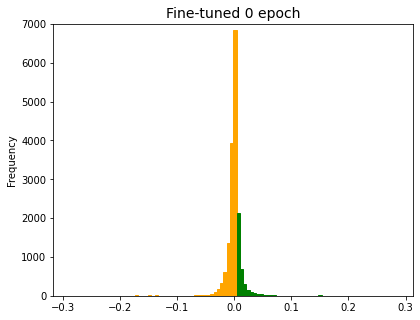

In [ ]:
import matplotlib.pyplot as plt
epochs = ['0']
fig, axs = plt.subplots(1, 1)

for i in range(1):
  prefix = "ms_v2_bert_" + epochs[i] + '/preds_dif_c_values_3'
  df = pd.read_csv(prefix)
  hists = df.plot.hist(df, xlabel='preds_df', bins = 100, legend = False, ax=axs, figsize=(6.45,5))
  axs.set_title('Fine-tuned {} epoch'.format(str(i)), fontsize = 14)
  axs.set_ylim(0, 7000)
  for h in hists.patches:
    if h.get_x() >= 0:
        h.set_color('g')
    else:
        h.set_color('orange')

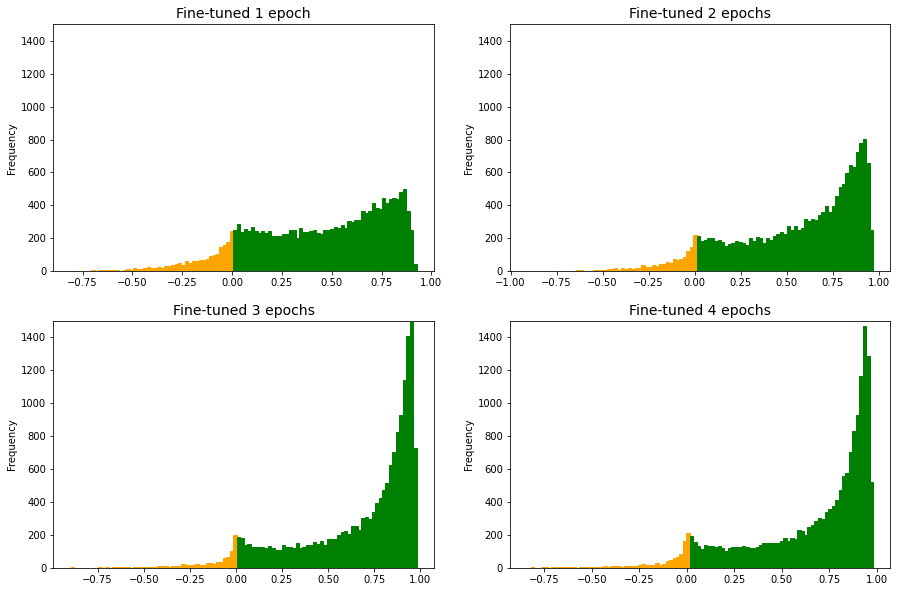

In [ ]:
import matplotlib.pyplot as plt
epochs = ['1', '2', '3', '4']
fig, axs = plt.subplots(2, 2)

for i in range(2):
  for j in range(2):
    prefix = "ms_v2_bert_" + epochs[i*2+j] + '/preds_dif_c_values_3'
    df = pd.read_csv(prefix)
    hists = df.plot.hist(df, xlabel='preds_df', bins = 100, legend = False, ax=axs[i][j], figsize=(15,10))
    if i == 0 and j == 0:
      axs[i][j].set_title('Fine-tuned {} epoch'.format(str(i*2+j+1)), fontsize = 14)
    else:
      axs[i][j].set_title('Fine-tuned {} epochs'.format(str(i*2+j+1)), fontsize = 14)
    axs[i][j].set_ylim(0, 1500)
    for h in hists.patches:
      if h.get_x() >= 0:
          h.set_color('g')
      else:
          h.set_color('orange')